In [1]:
import torch
import tqdm
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
from segmentation_models_pytorch.utils.meter import AverageValueMeter
from torch.utils.data import DataLoader, random_split
from utils.image_loading import load_training_images, load_groundtruth_images, load_test_images
from custom_datasets import Sat_Mask_Dataset_UPP_preprocessed
import albumentations as album
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
from torcheval.metrics.functional import multiclass_f1_score

/opt/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Check if GPU is available
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: mps


In [3]:
# Preprocessing function
preprocess_input = get_preprocessing_fn('efficientnet-b5', pretrained='imagenet')
preprocess_input =  album.Compose([album.Lambda(image=preprocess_input), ToTensorV2()])

In [4]:
# Load original data
original_data = {}
original_data["images"] = load_training_images()
original_data["images"].extend(load_groundtruth_images("EPFL"))
original_data["masks"] = load_groundtruth_images()
original_data["masks"].extend(load_groundtruth_images("EPFL"))

In [5]:
# Load custom data for specified cities
city_names = ["boston", "nyc", "philadelphia", "austin"]
custom_data = {"images": [], "masks": []}
for name in city_names:
    custom_data["images"].extend(load_training_images(name))
    custom_data["masks"].extend(load_groundtruth_images(name))

In [6]:
# Create datasets
custom_data_set = Sat_Mask_Dataset_UPP_preprocessed(custom_data["images"], custom_data["masks"], min_street_ratio=0.03, max_street_ratio=1.0, upp_preprocess=preprocess_input)
original_data_set = Sat_Mask_Dataset_UPP_preprocessed(original_data["images"], original_data["masks"],  upp_preprocess=preprocess_input)
print("After cleanup, the dataset now contains", len(custom_data_set), "images")

Initialized dataset, checked for min,max street ratio. Discarded %: 0.10558751027115859  num discarded: 1028
Initialized dataset, checked for min,max street ratio. Discarded %: 0.0  num discarded: 0
After cleanup, the dataset now contains 8708 images


(400, 400, 3)


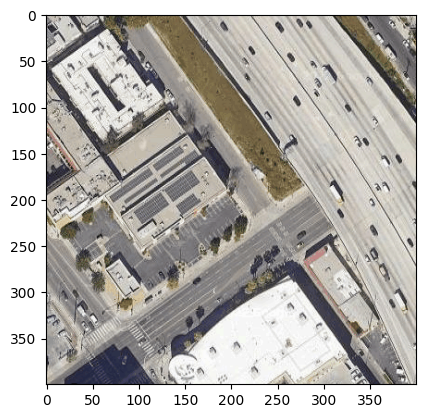

(400, 400, 3)


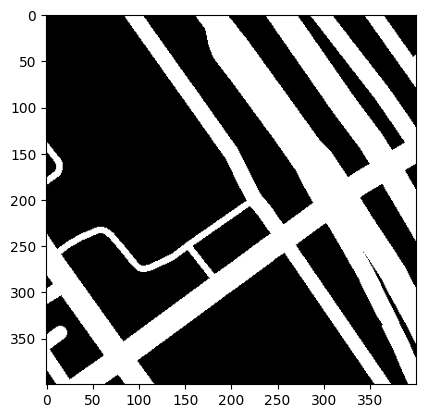

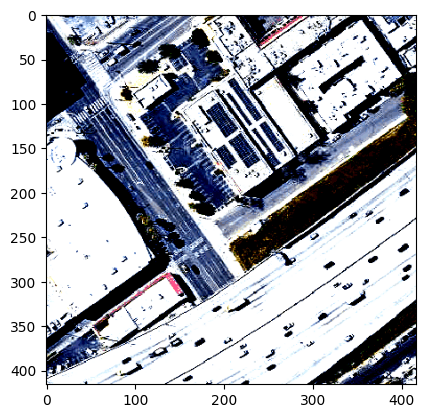

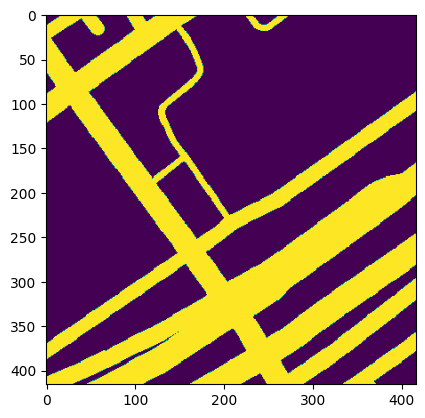

In [7]:
import numpy as np
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

print(original_data["images"][0].shape)
plt.imshow(original_data["images"][0])
plt.show()
print(original_data["masks"][0].shape)
plt.imshow(original_data["masks"][0])
plt.show()
item = original_data_set.__getitem__(0)
img_normal = np.swapaxes(item[0], 0, 2)
img_mask = np.swapaxes(item[1], 0, 2)
plt.imshow(img_normal)
plt.show()
plt.imshow(img_mask.squeeze(0))
plt.show()

In [40]:
# Split datasets into training and validation sets
train_size = int(0.8 * len(custom_data_set))
valid_size = len(custom_data_set) - train_size
train_dataset, valid_dataset = random_split(custom_data_set, [train_size, valid_size])

# Create data loaders
batch_size = 5
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

#### Configure UnetPlusPlus Model

In [9]:
# Define the model
model = smp.UnetPlusPlus(
    encoder_name="efficientnet-b5",
    encoder_depth=5,
    encoder_weights="imagenet",
    decoder_use_batchnorm=True,
    decoder_channels=(1024,512,256,64,16),
    decoder_attention_type=None,
    in_channels=3,
    classes=1,
    activation=None,
    aux_params=None
).to(device)

In [10]:
class_weights = torch.tensor([1./0.13]).to(device)
bce_loss = nn.BCEWithLogitsLoss(weight=class_weights)

def dice_loss(logits,masks, smooth=1e-6):
    probs = torch.sigmoid(logits)
    probs_flat = probs.reshape(-1)
    masks_flat = masks.reshape(-1)
    
    intersection = (probs_flat * masks_flat).sum()
    union = probs_flat.sum() + masks_flat.sum()
    dice_coeff = (2.0 * intersection + smooth) / (union + smooth)
    return 1.0 - dice_coeff

def combined_loss_correct_dice(logits, masks, alpha=0.15, gamma=2.0, smooth=1e-6):
    # reshape the mask and predictions for the bce loss: 
    batch_size = logits.shape[0]
    logits_sq = logits.reshape((batch_size, 416*416))
    mask_sq = masks.reshape((batch_size, 416*416))
    
    return dice_loss(logits, masks, smooth=smooth) + bce_loss(logits_sq, mask_sq)

In [11]:
def mean_f1_score_from_logits(pred, mask):
    # assume both inputs have the shape (batchsize,1, h,w), where h=w=1024
    # compute the mean for all the images
    # computes the mean over the 0-th axis
    pred_classes = torch.round(torch.sigmoid(pred))
    return mean_f1_score_from_classes(mask,pred_classes)


def mean_f1_score_from_classes(preds,masks):
    
    # assume both inputs have the shape (batchsize,1, h,w), where h=w=1024
    # this computes the f1 over the whole batch, for each image in the batch alone:
    
    # first reshape the tensors
    b_size = masks.shape[0]
    f1_acc = 0.
    size = torch.prod(torch.tensor(masks.shape[1:]))
    for i in range(b_size):
        mask = masks[i]
        pred = preds[i]
        # reshape and compute f1
        f1_acc = f1_acc + multiclass_f1_score(pred.reshape((size)), mask.reshape((size)))
        
    mean_f1 = f1_acc/b_size
    return mean_f1

In [12]:
# Define optimizer, scheduler, and loss function
optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.0001)])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=10, verbose=True, threshold=1e-6, factor=0.5)

/opt/miniconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [13]:
print("Model loaded")
# how many trainable parameters does the model have?
print("Trainable parameters",sum(p.numel() for p in model.parameters() if p.requires_grad))
# how many total parameters does the model have?
print("Total parameters",sum(p.numel() for p in model.parameters()))

# percentage of trainable parameters
print("Percentage of trainable parameters: ")
print(sum(p.numel() for p in model.parameters() if p.requires_grad) / sum(p.numel() for p in model.parameters()))

Model loaded
Trainable parameters 54679105
Total parameters 54679105
Percentage of trainable parameters: 
1.0


#### Load The Data

torch.Size([3, 416, 416])
torch.Size([1, 416, 416])


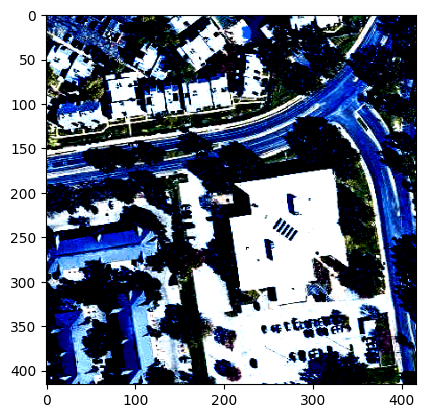

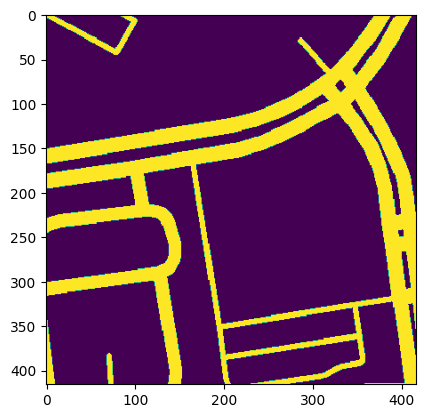

In [14]:
import matplotlib.pyplot as plt
import numpy as np 

item = train_loader.dataset[0]
print(item[0].shape)
print(item[1].shape)
img_normal = np.swapaxes(item[0], 0, 2)
img_mask = np.swapaxes(item[1], 0, 2)
plt.imshow(img_normal)
plt.show()
plt.imshow(img_mask)
plt.show()

In [44]:
# Training loop
for epoch in range(20):
    model.train()
    average_loss = 0
    f1_score = 0

    for data in tqdm.tqdm(train_loader, leave=False):
        x, y = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        y_pred = model.forward(x)

        loss = combined_loss_correct_dice(y_pred, y)
        loss.backward()
        optimizer.step()

        # Update loss and f1
        average_loss += loss.item()
        f1_score += mean_f1_score_from_logits(y_pred, y)

    # Print training logs for the current epoch
    print(f"Epoch: {epoch}, Training Loss: {average_loss / len(train_loader)}, F1: {f1_score / len(train_loader)}")#, IOU: {metrics_meters["iou_score"]}, Accuracy: {metrics_meters["accuracy"]}")

    torch.save(model.state_dict(), f"best_model_{epoch}.pth")
    # Validation loop
    model.eval()
    average_loss = AverageValueMeter()
    f1_score = AverageValueMeter()

    for x, y in tqdm.tqdm(valid_loader):
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            y_pred = model.forward(x)
            loss = combined_loss_correct_dice(y_pred, y)

        # Update loss and f1
        average_loss += loss.item()
        f1_score += mean_f1_score_from_logits(y_pred, y)

    # Print training logs for the current epoch
    print(f"Epoch: {epoch}, Training Loss: {average_loss / len(valid_loader)}, F1: {f1_score / len(valid_loader)}")#, IOU: {metrics_meters["iou_score"]}, Accuracy: {metrics_meters["accuracy"]}")

  0%|          | 1/1394 [00:01<28:14,  1.22s/it]

Epoch: 0, Training Loss: 0.4822342872619629, F1: 0.18305703997612


  0%|          | 2/1394 [00:02<24:08,  1.04s/it]

Epoch: 0, Training Loss: 0.7787885665893555, F1: 0.18832239508628845


  0%|          | 3/1394 [00:03<22:58,  1.01it/s]

Epoch: 0, Training Loss: 1.0430904865264892, F1: 0.18939927220344543


  0%|          | 4/1394 [00:03<22:18,  1.04it/s]

Epoch: 0, Training Loss: 1.301319432258606, F1: 0.1901872307062149


  0%|          | 5/1394 [00:04<21:49,  1.06it/s]

Epoch: 0, Training Loss: 1.5834375619888306, F1: 0.1890833079814911


  0%|          | 6/1394 [00:05<21:32,  1.07it/s]

Epoch: 0, Training Loss: 1.8331997394561768, F1: 0.19012367725372314


  1%|          | 7/1394 [00:06<21:25,  1.08it/s]

Epoch: 0, Training Loss: 2.079720640182495, F1: 0.18977580964565277


  1%|          | 8/1394 [00:07<21:12,  1.09it/s]

Epoch: 0, Training Loss: 2.384291887283325, F1: 0.1877886950969696


  1%|          | 9/1394 [00:08<21:09,  1.09it/s]

Epoch: 0, Training Loss: 2.688354659080505, F1: 0.18771034479141235


  1%|          | 10/1394 [00:09<21:05,  1.09it/s]

Epoch: 0, Training Loss: 2.978402280807495, F1: 0.18961606919765472


  1%|          | 11/1394 [00:10<21:05,  1.09it/s]

Epoch: 0, Training Loss: 3.218638300895691, F1: 0.1909818947315216


  1%|          | 12/1394 [00:11<21:13,  1.09it/s]

Epoch: 0, Training Loss: 3.4282857894897463, F1: 0.19179385900497437


  1%|          | 13/1394 [00:12<21:08,  1.09it/s]

Epoch: 0, Training Loss: 3.7579813957214356, F1: 0.186862975358963


KeyboardInterrupt: 

torch.Size([3, 416, 416])
torch.Size([1, 416, 416])


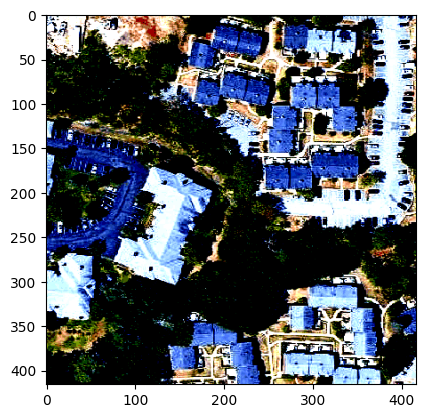

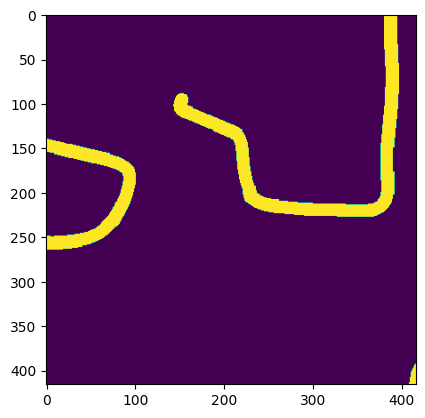

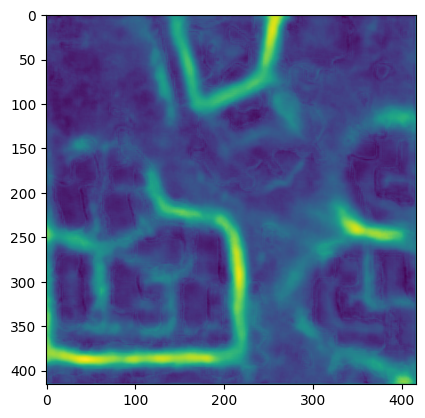

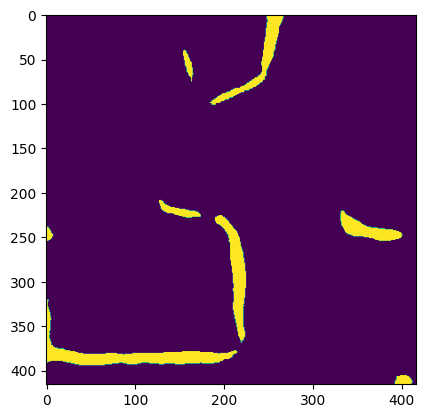

In [55]:
import matplotlib.pyplot as plt
import numpy as np 

item = valid_loader.dataset[0]
print(item[0].shape)
print(item[1].shape)
img_normal = np.swapaxes(item[0], 0, 2)
img_mask = np.swapaxes(item[1], 0, 2)
plt.imshow(img_normal)
plt.show()
plt.imshow(img_mask)
plt.show()
model.eval()
pred = None
with torch.no_grad():
    image = item[0].unsqueeze(0).to(device)
    pred = model(image).cpu()
plt.imshow(pred.squeeze())
plt.show()
plt.imshow(torch.round(torch.sigmoid(pred.squeeze())))
plt.show()

In [54]:
print(pred.max())

tensor(3.7116)


In [ ]:
# Load the saved model for further training on the original dataset
model.load_state_dict(torch.load("best_model_pre_20.pth"))

<All keys matched successfully>

In [28]:
# Split the original dataset into training and validation sets
train_size = int(0.8 * len(original_data_set))
valid_size = len(original_data_set) - train_size
train_dataset, valid_dataset = random_split(original_data_set, [train_size, valid_size])

# Create new data loaders for the original dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

In [ ]:
# Continue training loop with the original dataset
for epoch in range(50):
    model.train()
    average_loss = 0
    f1_score = 0

    for x, y in tqdm.tqdm(train_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model.forward(x)

        loss = combined_loss_correct_dice(y_pred, y)
        loss.backward()
        optimizer.step()

        # Update loss and f1
        average_loss += loss.item()
        f1_score += mean_f1_score_from_logits(y_pred, y)
        
    
    # Print training logs for the current epoch
    print(f"Epoch: {epoch}, Training Loss: {average_loss / len(train_loader)}, F1: {f1_score / len(train_loader)}")#, IOU: {metrics_meters["iou_score"]}, Accuracy: {metrics_meters["accuracy"]}")

    torch.save(model.state_dict(), f"best_model_postprocess_{epoch}.pth")
    # Validation loop
    model.eval()
    average_loss =0
    f1_score = 0

    for x, y in valid_loader:
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            y_pred = model.forward(x)
            loss = combined_loss_correct_dice(y_pred, y)

        # Update loss and f1
        # Update loss and f1
        average_loss += loss.item()
        f1_score += mean_f1_score_from_logits(y_pred, y)
    
    # Print training logs for the current epoch
    print(f"Epoch: {epoch}, Training Loss: {average_loss / len(valid_loader)}, F1: {f1_score / len(valid_loader)}")#, IOU: {metrics_meters["iou_score"]}, Accuracy: {metrics_meters["accuracy"]}")

100%|██████████| 4/4 [00:12<00:00,  3.14s/it]


Epoch 1 - Training Loss: 0.2229, f1_score: 0.7606, iou_score: 0.6145, accuracy: 0.9252
Epoch 1 - Validation Loss: 0.2483, f1_score: 0.7854, iou_score: 0.6466, accuracy: 0.9254


  1%|          | 1/100 [00:15<25:49, 15.65s/it]

New best model found at epoch 1 with IoU score: 0.6466


100%|██████████| 4/4 [00:07<00:00,  1.99s/it]


Epoch 2 - Training Loss: 0.1723, f1_score: 0.7717, iou_score: 0.6284, accuracy: 0.9308


  2%|▏         | 2/100 [00:24<18:50, 11.53s/it]

Epoch 2 - Validation Loss: 0.3992, f1_score: 0.7430, iou_score: 0.5911, accuracy: 0.9161


100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


Epoch 3 - Training Loss: 0.1623, f1_score: 0.7582, iou_score: 0.6108, accuracy: 0.9291


  3%|▎         | 3/100 [00:33<16:56, 10.48s/it]

Epoch 3 - Validation Loss: 0.3263, f1_score: 0.7743, iou_score: 0.6317, accuracy: 0.9230


100%|██████████| 4/4 [00:11<00:00,  2.95s/it]


Epoch 4 - Training Loss: 0.1477, f1_score: 0.7980, iou_score: 0.6642, accuracy: 0.9380


  4%|▍         | 4/100 [00:46<18:02, 11.27s/it]

Epoch 4 - Validation Loss: 0.2347, f1_score: 0.7766, iou_score: 0.6347, accuracy: 0.9233


100%|██████████| 4/4 [00:09<00:00,  2.27s/it]


Epoch 5 - Training Loss: 0.1448, f1_score: 0.8160, iou_score: 0.6892, accuracy: 0.9412


  5%|▌         | 5/100 [00:56<17:15, 10.90s/it]

Epoch 5 - Validation Loss: 0.2122, f1_score: 0.7759, iou_score: 0.6338, accuracy: 0.9236


100%|██████████| 4/4 [00:08<00:00,  2.16s/it]


Epoch 6 - Training Loss: 0.1370, f1_score: 0.8204, iou_score: 0.6955, accuracy: 0.9428


  6%|▌         | 6/100 [01:05<16:18, 10.41s/it]

Epoch 6 - Validation Loss: 0.1960, f1_score: 0.7850, iou_score: 0.6461, accuracy: 0.9266


100%|██████████| 4/4 [00:09<00:00,  2.33s/it]


Epoch 7 - Training Loss: 0.1342, f1_score: 0.8191, iou_score: 0.6938, accuracy: 0.9432
Epoch 7 - Validation Loss: 0.1910, f1_score: 0.7867, iou_score: 0.6484, accuracy: 0.9267


  7%|▋         | 7/100 [01:16<16:14, 10.48s/it]

New best model found at epoch 7 with IoU score: 0.6484


100%|██████████| 4/4 [00:08<00:00,  2.15s/it]


Epoch 8 - Training Loss: 0.1280, f1_score: 0.8292, iou_score: 0.7082, accuracy: 0.9457
Epoch 8 - Validation Loss: 0.1878, f1_score: 0.7919, iou_score: 0.6555, accuracy: 0.9279


  8%|▊         | 8/100 [01:26<15:42, 10.25s/it]

New best model found at epoch 8 with IoU score: 0.6555


100%|██████████| 4/4 [00:11<00:00,  2.82s/it]


Epoch 9 - Training Loss: 0.1239, f1_score: 0.8349, iou_score: 0.7168, accuracy: 0.9472
Epoch 9 - Validation Loss: 0.1827, f1_score: 0.8029, iou_score: 0.6707, accuracy: 0.9310


  9%|▉         | 9/100 [01:38<16:39, 10.99s/it]

New best model found at epoch 9 with IoU score: 0.6707


100%|██████████| 4/4 [00:09<00:00,  2.48s/it]


Epoch 10 - Training Loss: 0.1241, f1_score: 0.8404, iou_score: 0.7249, accuracy: 0.9483


 10%|█         | 10/100 [01:49<16:20, 10.90s/it]

Epoch 10 - Validation Loss: 0.1885, f1_score: 0.7979, iou_score: 0.6638, accuracy: 0.9290


100%|██████████| 4/4 [00:08<00:00,  2.11s/it]


Epoch 11 - Training Loss: 0.1174, f1_score: 0.8508, iou_score: 0.7404, accuracy: 0.9515
Epoch 11 - Validation Loss: 0.1836, f1_score: 0.8042, iou_score: 0.6725, accuracy: 0.9309


 11%|█         | 11/100 [01:59<15:40, 10.57s/it]

New best model found at epoch 11 with IoU score: 0.6725


100%|██████████| 4/4 [00:11<00:00,  2.83s/it]


Epoch 12 - Training Loss: 0.1131, f1_score: 0.8501, iou_score: 0.7393, accuracy: 0.9516


 12%|█▏        | 12/100 [02:11<16:14, 11.08s/it]

Epoch 12 - Validation Loss: 0.1844, f1_score: 0.8019, iou_score: 0.6693, accuracy: 0.9302


100%|██████████| 4/4 [00:08<00:00,  2.09s/it]


Epoch 13 - Training Loss: 0.1122, f1_score: 0.8528, iou_score: 0.7435, accuracy: 0.9522


 13%|█▎        | 13/100 [02:20<15:11, 10.47s/it]

Epoch 13 - Validation Loss: 0.1865, f1_score: 0.8030, iou_score: 0.6709, accuracy: 0.9310


100%|██████████| 4/4 [00:09<00:00,  2.47s/it]


Epoch 14 - Training Loss: 0.1074, f1_score: 0.8601, iou_score: 0.7547, accuracy: 0.9543
Epoch 14 - Validation Loss: 0.1861, f1_score: 0.8065, iou_score: 0.6757, accuracy: 0.9312


 14%|█▍        | 14/100 [02:31<15:18, 10.68s/it]

New best model found at epoch 14 with IoU score: 0.6757


100%|██████████| 4/4 [00:12<00:00,  3.07s/it]


Epoch 15 - Training Loss: 0.1072, f1_score: 0.8641, iou_score: 0.7607, accuracy: 0.9552


 15%|█▌        | 15/100 [02:45<16:18, 11.52s/it]

Epoch 15 - Validation Loss: 0.1898, f1_score: 0.8041, iou_score: 0.6724, accuracy: 0.9303


100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


Epoch 16 - Training Loss: 0.1034, f1_score: 0.8677, iou_score: 0.7663, accuracy: 0.9566


 16%|█▌        | 16/100 [02:54<15:09, 10.83s/it]

Epoch 16 - Validation Loss: 0.1907, f1_score: 0.8043, iou_score: 0.6727, accuracy: 0.9308


100%|██████████| 4/4 [00:08<00:00,  2.17s/it]


Epoch 17 - Training Loss: 0.1058, f1_score: 0.8625, iou_score: 0.7583, accuracy: 0.9552


 17%|█▋        | 17/100 [03:03<14:27, 10.46s/it]

Epoch 17 - Validation Loss: 0.1950, f1_score: 0.8034, iou_score: 0.6715, accuracy: 0.9299


100%|██████████| 4/4 [00:07<00:00,  1.92s/it]


Epoch 18 - Training Loss: 0.1015, f1_score: 0.8654, iou_score: 0.7627, accuracy: 0.9563
Epoch 18 - Validation Loss: 0.1880, f1_score: 0.8093, iou_score: 0.6797, accuracy: 0.9319


 18%|█▊        | 18/100 [03:12<13:41, 10.02s/it]

New best model found at epoch 18 with IoU score: 0.6797


100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


Epoch 19 - Training Loss: 0.1004, f1_score: 0.8696, iou_score: 0.7694, accuracy: 0.9575
Epoch 19 - Validation Loss: 0.1860, f1_score: 0.8151, iou_score: 0.6880, accuracy: 0.9340


 19%|█▉        | 19/100 [03:22<13:22,  9.90s/it]

New best model found at epoch 19 with IoU score: 0.6880


100%|██████████| 4/4 [00:08<00:00,  2.17s/it]


Epoch 20 - Training Loss: 0.0996, f1_score: 0.8713, iou_score: 0.7720, accuracy: 0.9577


 20%|██        | 20/100 [03:32<13:00,  9.76s/it]

Epoch 20 - Validation Loss: 0.1915, f1_score: 0.8070, iou_score: 0.6765, accuracy: 0.9315


100%|██████████| 4/4 [00:07<00:00,  1.93s/it]


Epoch 21 - Training Loss: 0.1003, f1_score: 0.8695, iou_score: 0.7692, accuracy: 0.9572


 21%|██        | 21/100 [03:40<12:21,  9.39s/it]

Epoch 21 - Validation Loss: 0.1887, f1_score: 0.8094, iou_score: 0.6798, accuracy: 0.9324


100%|██████████| 4/4 [00:07<00:00,  1.89s/it]


Epoch 22 - Training Loss: 0.0970, f1_score: 0.8746, iou_score: 0.7771, accuracy: 0.9588


 22%|██▏       | 22/100 [03:48<11:46,  9.06s/it]

Epoch 22 - Validation Loss: 0.1921, f1_score: 0.8106, iou_score: 0.6815, accuracy: 0.9326


100%|██████████| 4/4 [00:07<00:00,  1.89s/it]


Epoch 23 - Training Loss: 0.0973, f1_score: 0.8744, iou_score: 0.7769, accuracy: 0.9585


 23%|██▎       | 23/100 [03:57<11:20,  8.84s/it]

Epoch 23 - Validation Loss: 0.1934, f1_score: 0.8086, iou_score: 0.6787, accuracy: 0.9322


100%|██████████| 4/4 [00:08<00:00,  2.08s/it]


Epoch 24 - Training Loss: 0.0936, f1_score: 0.8791, iou_score: 0.7842, accuracy: 0.9601


 24%|██▍       | 24/100 [04:06<11:19,  8.94s/it]

Epoch 24 - Validation Loss: 0.1920, f1_score: 0.8065, iou_score: 0.6757, accuracy: 0.9312


100%|██████████| 4/4 [00:07<00:00,  1.96s/it]


Epoch 25 - Training Loss: 0.0947, f1_score: 0.8773, iou_score: 0.7815, accuracy: 0.9597


 25%|██▌       | 25/100 [04:14<11:01,  8.82s/it]

Epoch 25 - Validation Loss: 0.1966, f1_score: 0.8094, iou_score: 0.6798, accuracy: 0.9317


100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


Epoch 26 - Training Loss: 0.0950, f1_score: 0.8775, iou_score: 0.7819, accuracy: 0.9597


 26%|██▌       | 26/100 [04:23<10:39,  8.64s/it]

Epoch 26 - Validation Loss: 0.1943, f1_score: 0.8056, iou_score: 0.6744, accuracy: 0.9303


100%|██████████| 4/4 [00:07<00:00,  1.96s/it]


Epoch 27 - Training Loss: 0.0974, f1_score: 0.8725, iou_score: 0.7742, accuracy: 0.9583


 27%|██▋       | 27/100 [04:31<10:30,  8.64s/it]

Epoch 27 - Validation Loss: 0.1909, f1_score: 0.8110, iou_score: 0.6821, accuracy: 0.9321


100%|██████████| 4/4 [00:07<00:00,  1.97s/it]


Epoch 28 - Training Loss: 0.0917, f1_score: 0.8818, iou_score: 0.7887, accuracy: 0.9611


 28%|██▊       | 28/100 [04:40<10:22,  8.64s/it]

Epoch 28 - Validation Loss: 0.1918, f1_score: 0.8107, iou_score: 0.6816, accuracy: 0.9319


100%|██████████| 4/4 [00:07<00:00,  1.90s/it]


Epoch 29 - Training Loss: 0.0928, f1_score: 0.8804, iou_score: 0.7867, accuracy: 0.9606


 28%|██▊       | 28/100 [04:48<12:22, 10.31s/it]

Epoch 29 - Validation Loss: 0.1882, f1_score: 0.8147, iou_score: 0.6874, accuracy: 0.9332
Final Validation IoU Score: 0.6880


In [ ]:
# Load the saved model for further training on the original dataset
model.load_state_dict(torch.load("best_model.pth"))

<All keys matched successfully>

In [ ]:
from custom_datasets import Sat_Only_Image_UPP_preprocessed
kaggle_submission_images = load_test_images()
submission_data_set = Sat_Only_Image_UPP_preprocessed(kaggle_submission_images, upp_preprocess=preprocess_input)

In [ ]:
submission_dataloader = DataLoader(submission_data_set, batch_size=5, shuffle=False, drop_last=False,num_workers=4,persistent_workers=True)

In [31]:
model.eval()
pair = valid_loader.dataset[0]
pred = None
with torch.no_grad():
    image = pair[0].unsqueeze(0).to(device)
    pred = model(image).cpu()

In [39]:
print(pred.squeeze())
print(torch.max(pred))
print(torch.mean(pred))

tensor([[-1.4943, -1.7795, -1.7901,  ..., -1.8271, -2.1925, -1.5988],
        [-1.7157, -2.2854, -2.5492,  ..., -2.4632, -2.7322, -2.2529],
        [-2.1087, -2.6535, -3.0633,  ..., -2.8296, -3.0998, -2.5898],
        ...,
        [-1.9418, -2.2222, -2.0022,  ..., -3.1398, -3.3472, -2.4947],
        [-1.9147, -2.7661, -2.5781,  ..., -3.1802, -3.2946, -2.5572],
        [-1.2243, -2.0253, -2.2525,  ..., -2.5875, -2.3229, -1.6117]])
tensor(-1.2243)
tensor(-3.4513)


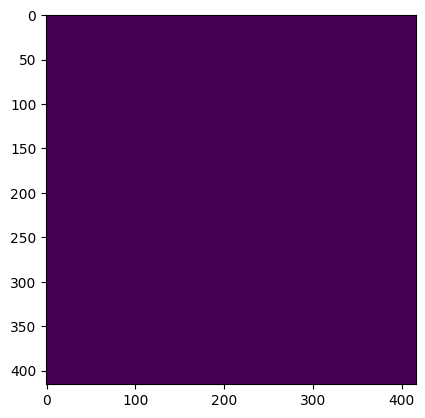

In [37]:
plt.imshow(torch.round(pred.squeeze())))
plt.show()

In [ ]:
import torch.nn as nn

from tqdm import tqdm

model.eval()
predictions = []

with torch.no_grad():
    for image in tqdm(submission_dataloader):
        image = image.to(device)
        pred = model(image)
        predictions.append(pred.cpu())

100%|██████████| 5/5 [00:09<00:00,  1.91s/it]


(400, 400, 3)
torch.Size([1, 224, 224])


TypeError: 'norm' must be an instance of matplotlib.colors.Normalize, str or None, not a int

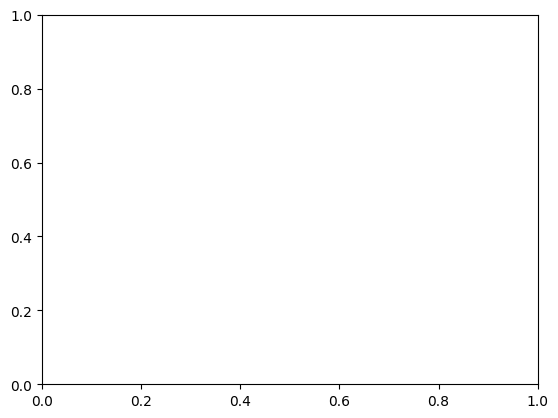

In [ ]:
import matplotlib.pyplot as plt
import numpy as np 

# item = train_loader.dataset[0]
print(kaggle_submission_images[0].shape)
print(predictions[0][0].shape)
pair = (kaggle_submission_images[0], predictions[0][0])
# img_normal = np.swapaxes(pair[0], 0, 2)
# img_mask = np.swapaxes(pair[1], 0, 2)
# img_pred = np.swapaxes(pred.cpu().squeeze(0), 0, 2)
# plt.imshow(original_data["images"][0])
# plt.show()
# plt.imshow(original_data["masks"][0])
# plt.show()
# plt.imshow(img_normal)
# plt.show()
# plt.imshow(img_mask)
# plt.show()
plt.imshow(predictions[0][0].cpu(), 0, 2)
plt.show()

In [ ]:
print(img_pred)

tensor([[[[-2.5221, -3.8234, -3.8182,  ..., -4.2388, -3.6264, -2.9442],
          [-3.4085, -5.6575, -5.9417,  ..., -0.8478, -0.8853, -1.1346],
          [-2.7028, -4.3069, -4.5098,  ...,  3.5135,  2.9964,  1.7035],
          ...,
          [-0.5951, -0.9178, -0.5282,  ..., -1.4758, -1.2464, -1.2590],
          [ 0.5641,  0.8815,  1.2751,  ..., -4.9448, -4.4396, -3.5964],
          [-2.9129, -4.6514, -4.7792,  ..., -3.5654, -3.2904, -2.7217]]],


        [[[-3.6215, -4.7063, -4.5939,  ..., -5.1554, -4.8056, -4.0087],
          [-5.1085, -7.8551, -8.1471,  ..., -1.0731, -1.4103, -1.6518],
          [-3.9173, -5.3848, -5.5356,  ...,  4.8652,  4.2019,  2.5869],
          ...,
          [-0.5219, -0.7393, -0.8206,  ..., -1.8740, -1.8794, -1.7474],
          [ 0.4601,  0.7070,  1.0137,  ..., -6.1031, -5.8872, -4.7383],
          [-4.3144, -5.9549, -5.9591,  ..., -4.1005, -4.0527, -3.4182]]],


        [[[-3.9075, -4.9695, -4.6381,  ..., -5.1253, -4.8971, -4.1916],
          [-5.4481, -8.167